# Stock Choice Decision Analysis
Code written and commentated by Peter Sanders
### Load Relevant Packages

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
import math
from scipy.special import expit
sns.set(style='whitegrid', context='talk')

### Define the Softmax Funcction to be used later

In [2]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

### Insert stock tickers

In [3]:
tickers = ["IFNNY", "INTC", "MCHP","ON","STM","SWKS","^VIX"]

### Set date range

In [4]:
start_date = datetime(2008,12,5)
end_date = datetime(2019,12,5)

### Get the data

In [68]:
df = data.DataReader(tickers, 'yahoo', start_date, end_date)

dates =[]
for x in range(len(df)):
    newdate = str(df.index[x])
    newdate = newdate[0:10]
    dates.append(newdate)

df['dates'] = dates

### Get only closing price data

In [69]:
close = df['Close']
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill')
close = close.rename(columns={"^VIX" : "VIX"})

In [70]:
for i in close:
    vars()[i] = close.loc[:,'%s' %i]

In [71]:
close = close.drop(columns="VIX")

In [72]:
close.describe()

Symbols,IFNNY,INTC,MCHP,ON,STM,SWKS
count,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000
mean,12.855310,30.804854,50.760247,11.430997,10.740401,52.595850
std,6.926812,11.023478,22.920534,5.395029,5.300483,33.743570
min,0.460000,12.080000,16.590000,2.950000,3.790000,3.810000
25%,7.952500,21.730000,33.595000,7.740000,7.212500,21.830000
50%,10.995000,28.180000,43.859999,9.380000,8.560000,46.200001
75%,17.637499,36.259998,69.040003,14.337500,13.755000,83.050003
max,31.100000,58.900002,103.309998,26.799999,26.240000,116.330002


### Get Covariance Matrix

In [73]:
cov =df['Close'].cov()
cov =cov.drop(columns="^VIX", index = "^VIX")

In [74]:
cov

Symbols,IFNNY,INTC,MCHP,ON,STM,SWKS
Symbols,,,,,,
IFNNY,47.945373,68.572776,152.441004,34.854983,31.659514,203.792405
INTC,68.572776,121.686470,237.439814,54.786674,46.397662,311.995988
MCHP,152.441004,237.439814,527.032205,117.850166,108.072491,663.383627
ON,34.854983,54.786674,117.850166,29.146432,26.783923,145.378894
STM,31.659514,46.397662,108.072491,26.783923,28.203312,119.323391
SWKS,203.792405,311.995988,663.383627,145.378894,119.323391,1140.450995


### Send Cov matrix to CSV

In [75]:
cov.to_csv(r'\Users\Pete\OneDrive\School\Grad\IE 512\Project 2\Project\cov.csv')

# Moving Average Time

### exponenetial weighted averages of closing prices

In [76]:
ema_short = close.ewm(span=30, adjust=False).mean()
ema_long = close.ewm(span=90, adjust=False).mean()
ema_loong = close.ewm(span=300, adjust=False).mean()

### Trading position

In [77]:
trading_positions_raw = ema_short - ema_long
trading_positions = trading_positions_raw.apply(np.sign) 
trading_positions_final = trading_positions.shift(1)

### Build Epsilon

In [82]:
q = abs(trading_positions_final.tail(30).mean())
r = abs(trading_positions_raw.tail(30).mean())
d = q*r
epsilon = expit(d)
print(epsilon)

Symbols
IFNNY    0.622059
INTC     0.942926
MCHP     0.891755
ON       0.597428
STM      0.882699
SWKS     0.997966
dtype: float64


### Lambda

In [67]:
Lambda = expit(np.log10(cov.sum()/10))
Lambda

Symbols
IFNNY    0.849608
INTC     0.872598
MCHP     0.905190
ON       0.833553
STM      0.825776
SWKS     0.917741
dtype: float64

### Chi

In [83]:
vix30=VIX.tail(30).mean()
pg = math.exp(1-abs(vix30-12)/12)
pb = math.exp(1-abs(vix30-30)/30)
Chi = softmax([pg,pb])
Chi
print(pb,pg)

1.5371208830095247 2.522428743947663


### Plot EMA vs Price

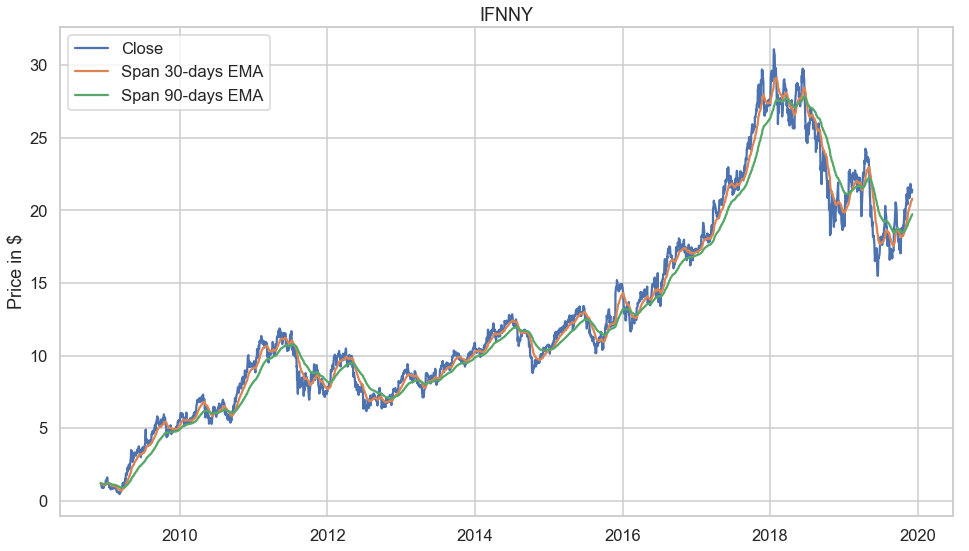

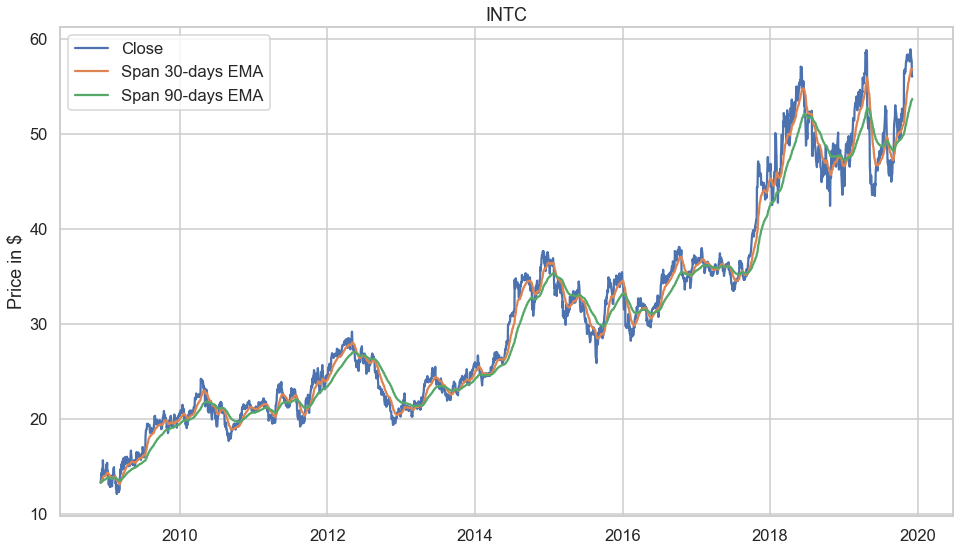

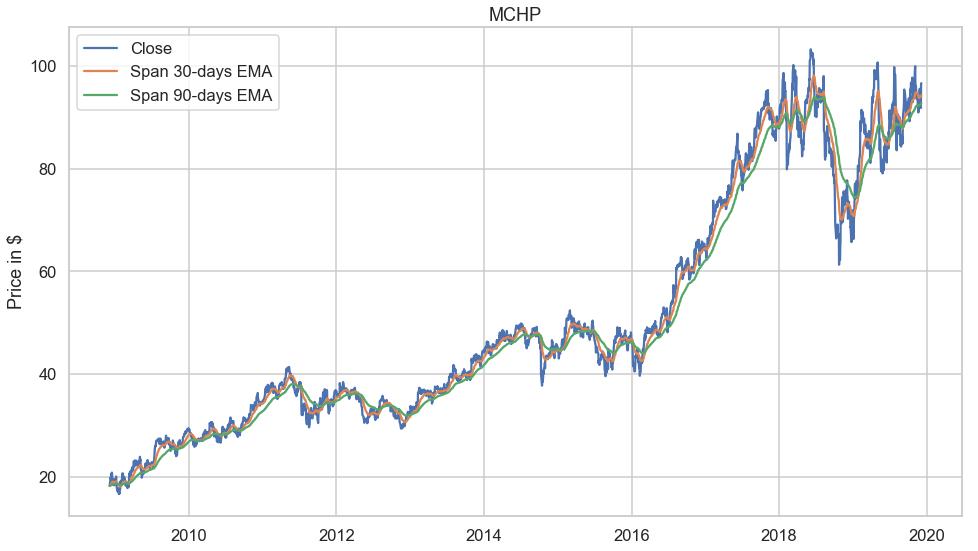

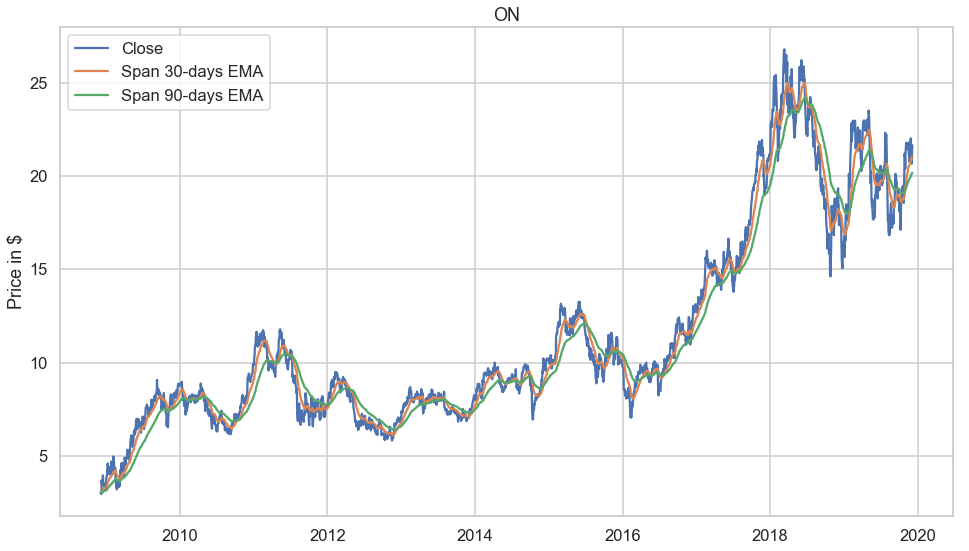

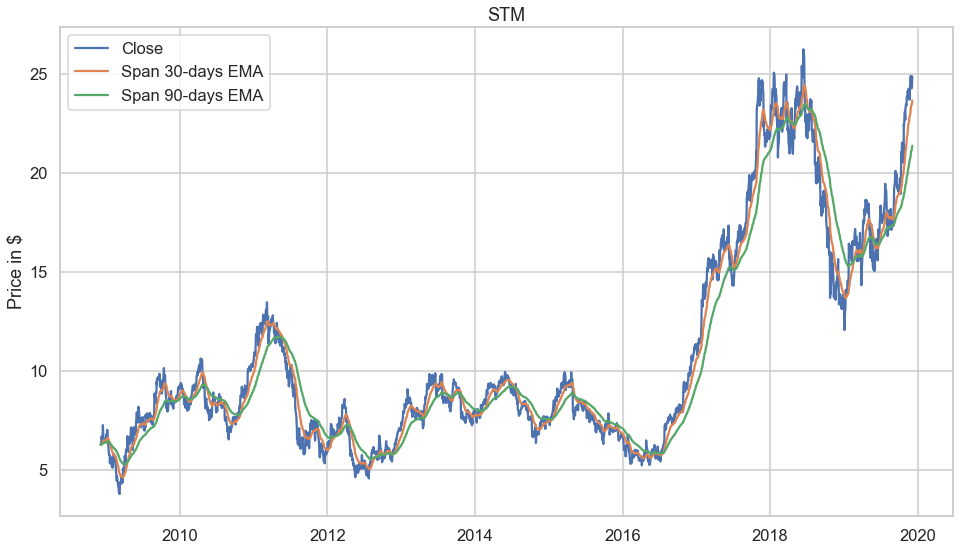

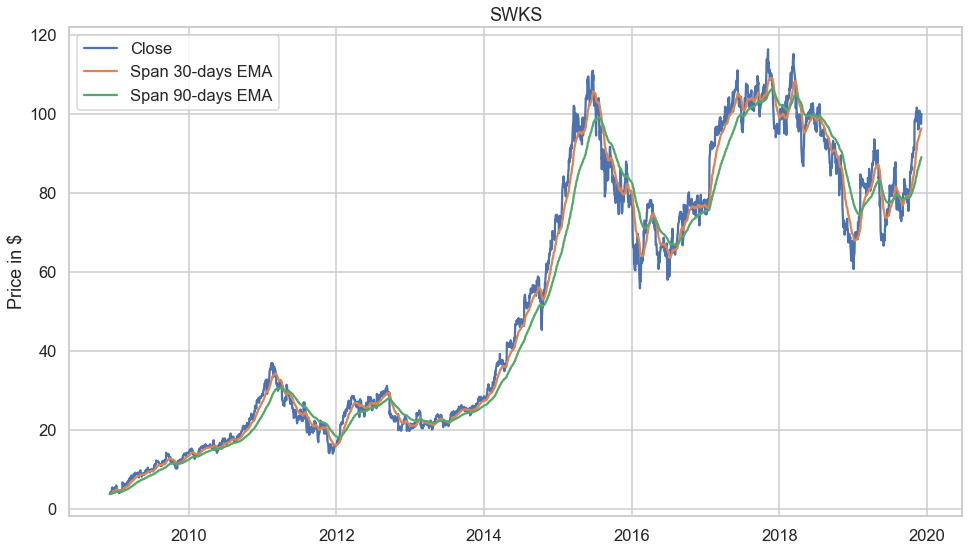

In [80]:
for i in close:
    fig, ax = plt.subplots(figsize=(16,9))


    ax.plot(close.loc[start_date:end_date, :].index, close.loc[start_date:end_date, i], label= 'Close')
    ax.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, i], label = 'Span 30-days EMA')
    ax.plot(ema_long.loc[start_date:end_date, :].index, ema_long.loc[start_date:end_date, i], label = 'Span 90-days EMA')
    #ax.plot(ema_loong.loc[start_date:end_date, :].index, ema_loong.loc[start_date:end_date, i], label = 'Span 180-days EMA')
    ax.legend(loc='best')
    ax.set_ylabel('Price in $')
    ax.set_title(i)


### Plot trading position vs PRice and EMA

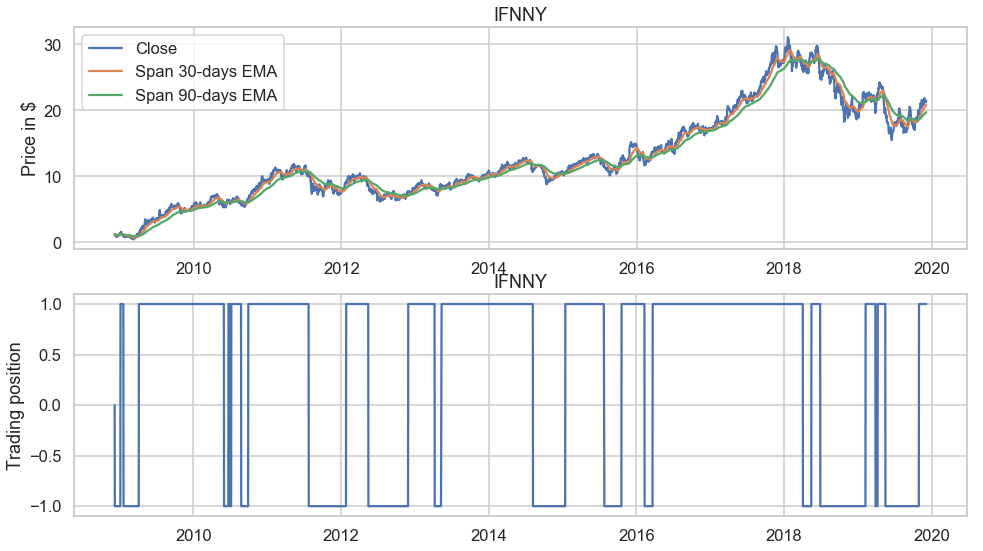

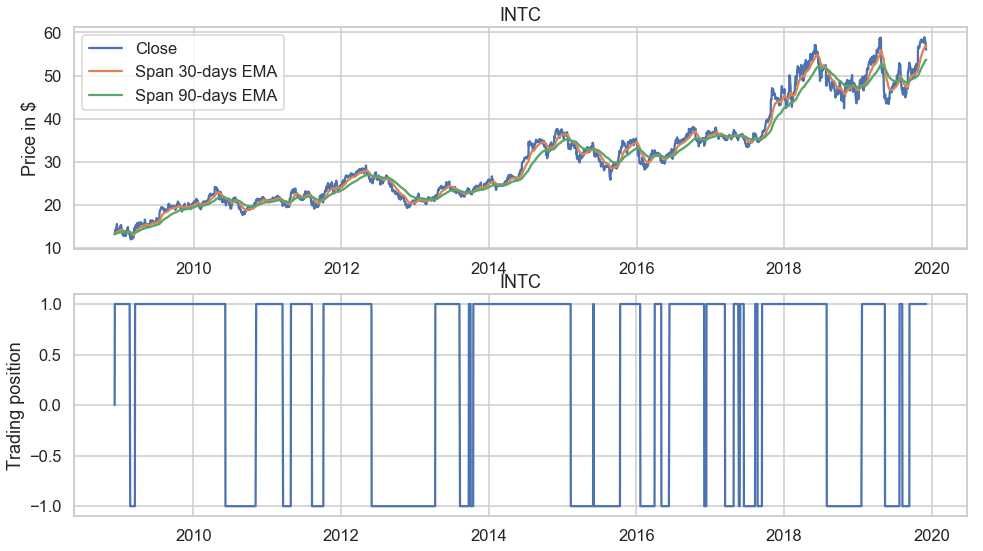

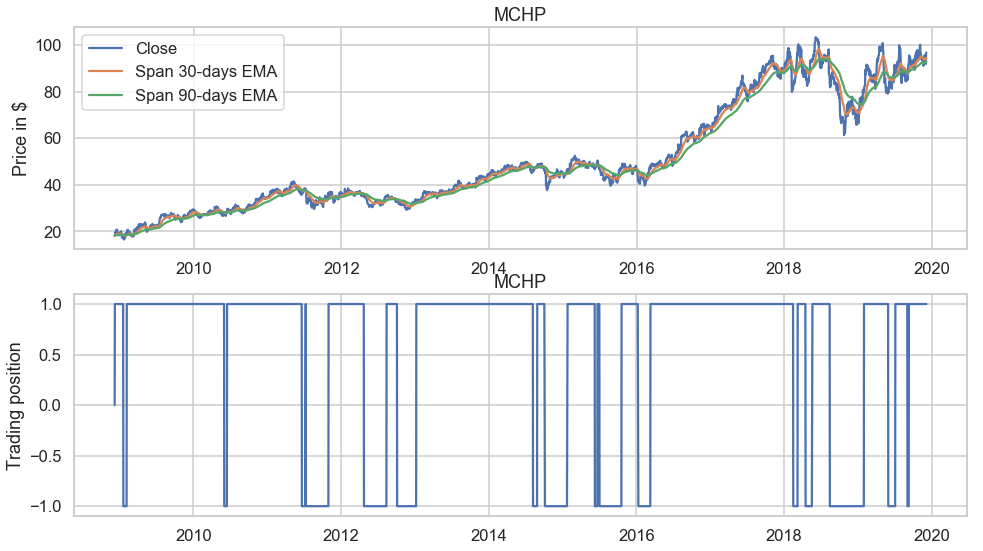

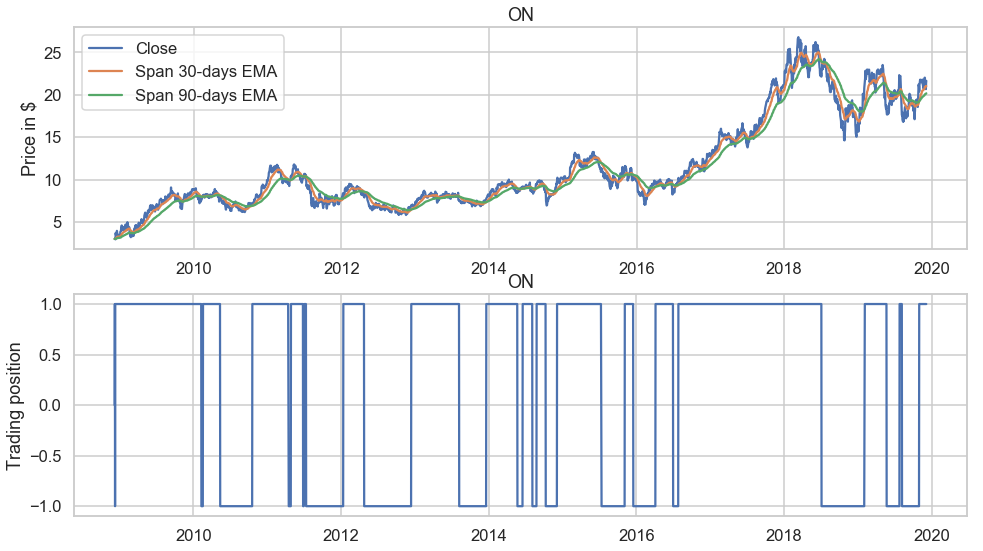

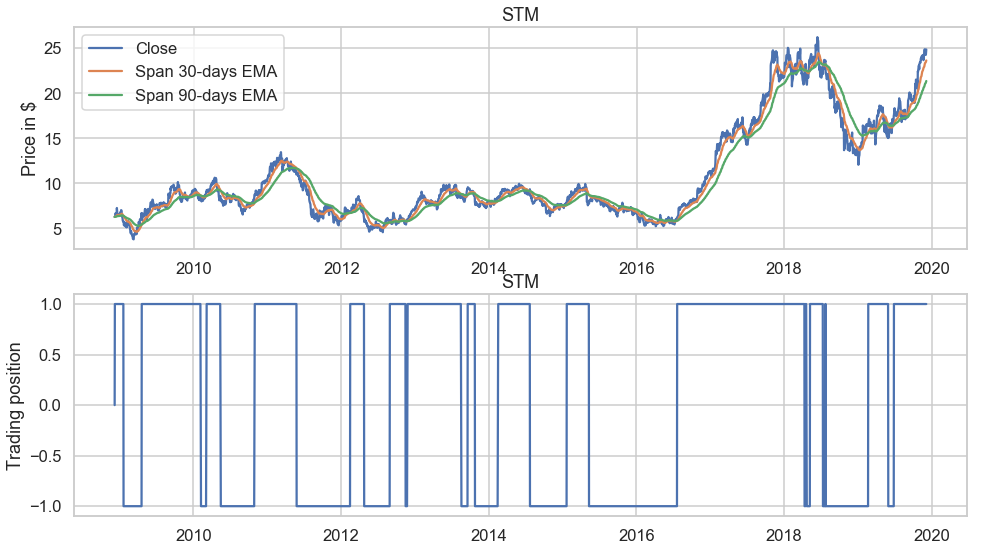

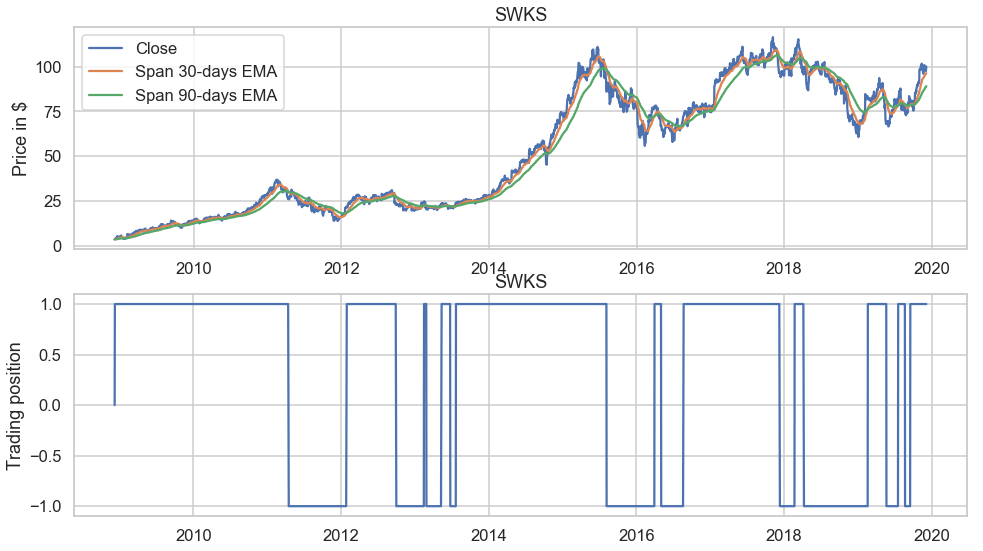

In [81]:
for i in close:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))
    ax1.set_title(i)
    ax1.plot(close.loc[start_date:end_date, :].index, close.loc[start_date:end_date, i], label= 'Close')
    ax1.plot(ema_short.loc[start_date:end_date, :].index, ema_short.loc[start_date:end_date, i], label = 'Span 30-days EMA')
    ax1.plot(ema_long.loc[start_date:end_date, :].index, ema_long.loc[start_date:end_date, i], label = 'Span 90-days EMA')
    #ax1.plot(ema_loong.loc[start_date:end_date, :].index, ema_loong.loc[start_date:end_date, i], label = 'Span 300-days EMA')
    ax1.legend(loc='best')
    ax1.set_ylabel('Price in $')

    ax2.set_title(i)
    ax2.plot(trading_positions_final.loc[start_date:end_date, :].index, trading_positions_final.loc[start_date:end_date, i], 
        label='Trading position')

    ax2.set_ylabel('Trading position')